In [1]:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Carrega o dataset como dataframe
df = pd.read_csv('dataset/video_games_2016.csv')

In [4]:
# Remove NAs
# df.dropna(inplace=True)

# Remove outliers
Q1 = df['Global_Sales'].quantile(0.02)
Q3 = df['Global_Sales'].quantile(0.98)

df = df[(df['Global_Sales'] >= Q1 ) & (df['Global_Sales'] <= Q3 )]

/tmp/ipykernel_3518713/3617597562.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


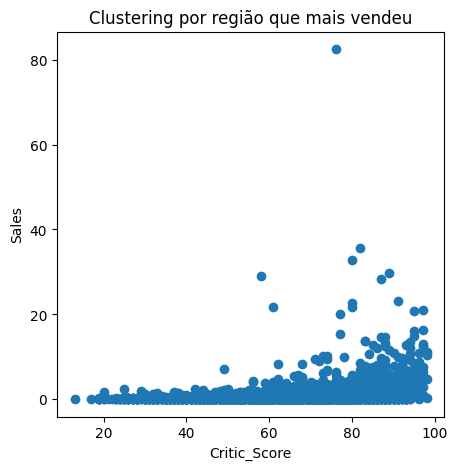

In [3]:

plt.figure(figsize=(5, 5))
plt.scatter( 
  df['Critic_Score'],
  df['Global_Sales'],

  cmap='viridis',
)

plt.ylabel('Sales')
plt.xlabel('Critic_Score')

plt.title('Clustering por região que mais vendeu')

plt.show()

KeyError: 'Rounded_Sales'

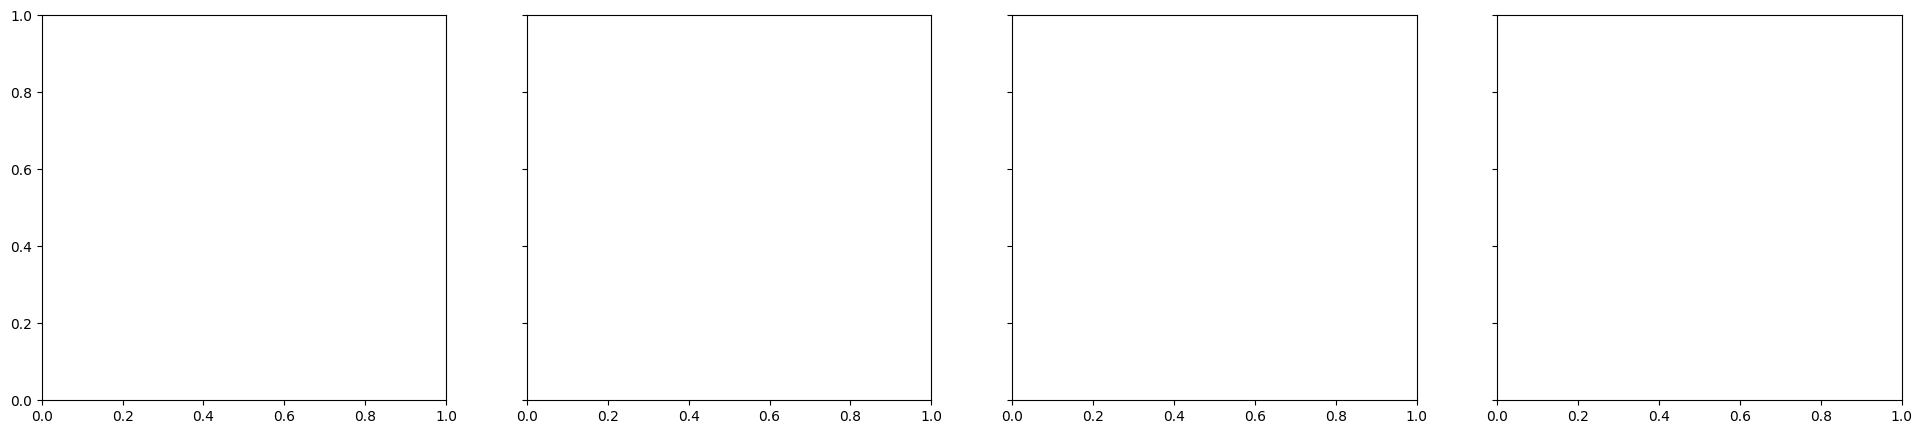

In [5]:
# Group by Critic_Score and calculate mean, median, mode, and min of Global_Sales
mean_sales = df.groupby('Critic_Score')['Global_Sales'].mean().reset_index()
median_sales = df.groupby('Critic_Score')['Global_Sales'].median().reset_index()
mode_sales = df.groupby('Critic_Score')['Global_Sales'].apply(lambda x: x.mode().iloc[0]).reset_index()
min_sales = df.groupby('Critic_Score')['Global_Sales'].min().reset_index()
# Create a figure with 4 subplots side by side
fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=True)

# Mean chart
axes[0].scatter(mean_sales['Critic_Score'], mean_sales['Global_Sales'], color='blue')
axes[0].set_title('Mean Global Sales by Critic Score')
axes[0].set_xlabel('Critic Score')
axes[0].set_ylabel('Global Sales')

# Median chart
axes[1].scatter(median_sales['Critic_Score'], median_sales['Global_Sales'], color='green')
axes[1].set_title('Median Global Sales by Critic Score')
axes[1].set_xlabel('Critic Score')

# Mode chart
# axes[2].scatter(mode_sales['Critic_Score'], mode_sales['Global_Sales'], color='red')
# axes[2].set_title('Mode Global Sales by Critic Score')
# axes[2].set_xlabel('Critic Score')

# Min chart
axes[3].scatter(min_sales['Critic_Score'], min_sales['Global_Sales'], color='purple')
axes[3].set_title('Min Rounded Sales by Critic Score')
axes[3].set_xlabel('Critic Score')

# Display the plots
plt.tight_layout()
plt.show()

In [103]:
# Cria coluna com a região que mais vendeu
column_to_number = {
    'NA_Sales':    "NA",
    'EU_Sales':    "EU",
    'JP_Sales':    "JP",
    'Other_Sales': "Outro" 
}

df['Greatest'] = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].idxmax(axis=1).map(column_to_number)
df['Critic_Classification'] = pd.cut(df['Critic_Score'], bins=4, labels=[1, 2, 3, 4])
df['Critic_Count_Classification'] = pd.cut(df['Critic_Count'], bins=4, labels=[1, 2, 3, 4])

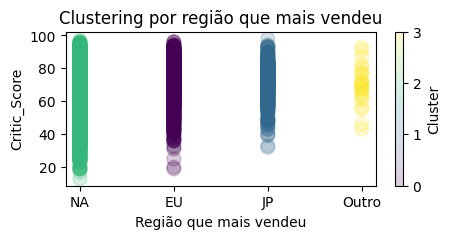

In [114]:
# from sklearn.cluster import KMeans
# from sklearn.linear_model import LinearRegression
from kmodes.kmodes import KModes 

# Colunas para embasar a clusterização
X = df[[ "Greatest" ]]

# Numero de clusters
n_clusters = 4

cluster_k = KModes( n_clusters=n_clusters, random_state=42 )
# cluster_k = KMeans( n_clusters=n_clusters, random_state=42 )

df['Cluster'] = cluster_k.fit_predict(X)

plt.figure(figsize=(5, 2))
plt.scatter( 
  df['Greatest'],
  df['Critic_Score'],

  c=df['Cluster'],
  cmap='viridis',
  s=100,
  alpha=0.2 
)

plt.xlabel('Região que mais vendeu')
plt.ylabel('Critic_Score')

plt.colorbar(label='Cluster')
plt.title('Clustering por região que mais vendeu')

plt.show()

In [105]:
# Transforma colunas categóricas em valores numéricos
# necessários para utilização de árvore de decisão

df["Publisher"] = df["Publisher"].astype('category').cat.codes
df["Platform"]  = df["Platform"].astype('category').cat.codes
df["Genre"]     = df["Genre"].astype('category').cat.codes
df["Developer"] = df["Developer"].astype('category').cat.codes
# df["Greatest"]  = df["Greatest"].astype('category').cat.codes
df["Rating"]    = df["Rating"].astype('category').cat.codes

# Preenche os NAs com 0
df["Critic_Score"] = df["Critic_Score"].fillna(0)
df["Critic_Count"] = df["Critic_Count"].fillna(0)
df["JP_Sales"]     = df["JP_Sales"].fillna(0)


In [106]:
# Arvore baseada em
X = np.array(df[[
    "Publisher",
    "Platform", 
    "Genre",
    "Developer",
    "Rating",
]])

# Saída : NA | EU | JP | Outros
y = np.array(df['Greatest'])

In [107]:
from sklearn.model_selection import train_test_split

# Dividindo os conjuntos de treinamento e teste
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.3)

In [108]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=3,
    random_seed=42,
    verbose=0
)

catboost_model.fit(X_treinamento, y_treinamento)
y_pred = catboost_model.predict(X_teste)

print("CatBoost Model Accuracy:", accuracy_score(y_teste, y_pred))
print("\nClassification Report:\n", classification_report(y_teste, y_pred))


CatBoost Model Accuracy: 0.8154484188698807

Classification Report:
               precision    recall  f1-score   support

          EU       0.79      0.55      0.65       351
          JP       0.59      0.21      0.31       153
          NA       0.83      0.95      0.89      1412
       Outro       0.00      0.00      0.00        13

    accuracy                           0.82      1929
   macro avg       0.55      0.43      0.46      1929
weighted avg       0.80      0.82      0.79      1929



c:\Users\mateu\OneDrive\Área de Trabalho\topicos-4-main\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mateu\OneDrive\Área de Trabalho\topicos-4-main\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mateu\OneDrive\Área de Trabalho\topicos-4-main\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [109]:
from sklearn import tree

modeloarvoredecisao = tree.DecisionTreeClassifier(criterion='entropy')     

In [110]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train Gradient Boosting model
gradient_boost = GradientBoostingClassifier(
    n_estimators=400,     # Adjust as needed
    learning_rate=0.1,    # Typical starting value for Gradient Boosting
    max_depth=3,          # Depth of each tree, adjust to avoid overfitting
    random_state=42
)

gradient_boost.fit(X_treinamento, y_treinamento)
y_pred = gradient_boost.predict(X_teste) 

# Evaluate the model's accuracy
accuracy = accuracy_score(y_teste, y_pred)

print("Gradient Model Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_teste, y_pred))

Gradient Model Accuracy: 0.8175220321410057

Classification Report:
               precision    recall  f1-score   support

          EU       0.76      0.60      0.67       351
          JP       0.58      0.31      0.40       153
          NA       0.84      0.94      0.89      1412
       Outro       0.00      0.00      0.00        13

    accuracy                           0.82      1929
   macro avg       0.55      0.46      0.49      1929
weighted avg       0.80      0.82      0.80      1929



In [111]:
modeloarvoredecisao.fit(X_treinamento, y_treinamento)
modeloarvoredecisao.score(X_treinamento, y_treinamento)

0.9744330813694976

In [112]:
from sklearn import metrics
y_predicao = modeloarvoredecisao.predict(X_teste)

print("Acurácia:",metrics.accuracy_score(y_teste, y_predicao))
print("Precisão:",metrics.precision_score(y_teste, y_predicao, average=None))
print("Recall:",metrics.recall_score(y_teste, y_predicao, average=None))
print("F1-score:",metrics.f1_score(y_teste, y_predicao, average=None))

Acurácia: 0.7527216174183515
Precisão: [0.55216285 0.41975309 0.85047411 0.33333333]
Recall: [0.61823362 0.44444444 0.82577904 0.07692308]
F1-score: [0.58333333 0.43174603 0.83794466 0.125     ]


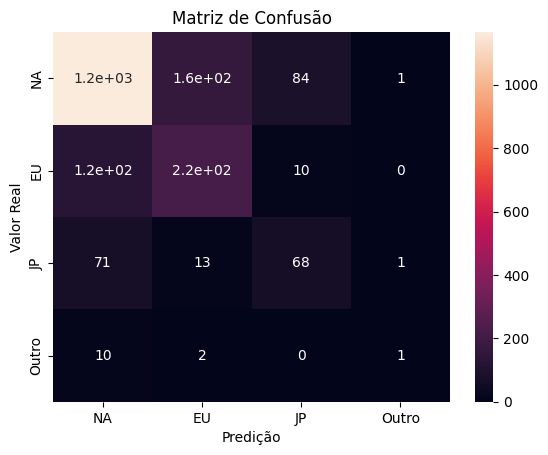

In [113]:
labels = ["NA", "EU", "JP", "Outro"]

matrizconfusao = metrics.confusion_matrix(y_teste, y_predicao, labels=labels)

ax = plt.subplot()

sns.heatmap(matrizconfusao, annot=True, ax = ax);

# labels, title and ticks
ax.set_xlabel('Predição');
ax.set_ylabel('Valor Real'); 
ax.set_title('Matriz de Confusão'); 
ax.xaxis.set_ticklabels( labels ); 
ax.yaxis.set_ticklabels( labels );